In [4]:
import os
import re
import typing as t
import numpy as np
import pandas as pd
import zipfile
from functools import partial
import matplotlib.pyplot as plt
from pathlib import Path

## load zip (py)

In [ ]:
ru = None
en = None

with zipfile.ZipFile('../storage/1mcorpus.zip') as zf:
    for filename in zf.namelist():
        if '.ru' in filename:
            with zf.open(filename) as f:
                ru = f.read().decode().split('\n')
        elif '.en' in filename:
            with zf.open(filename) as f:
                en = f.read().decode().split('\n')

ru[:5], en[:5], len(ru), len(en)

# \<sos\>

In [5]:
import torchtext
import torchdata
from torchdata import datapipes
from torchdata.datapipes.iter import FileLister, FileOpener, IterableWrapper, StreamReader
from torchtext import transforms
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cpu'

try:
    print(torch.__version__, torch.cuda.is_available(), torch.cuda.get_device_name(torch.cuda.current_device()), torchtext.__version__, torchdata.__version__)
except Exception as e:
    print(':(', e)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.0.0 True Tesla T4 0.15.1 0.6.0


In [6]:
SEED = 212

# random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
from itertools import islice


def print_datapipe(datapipe: datapipes.iter.IterDataPipe | t.Iterable, n: int = None) -> None:
    print(type(datapipe))

    for sample in islice(datapipe, n):
        print(sample)

## load zip (torch)

In [ ]:
datapipe = FileLister('../storage', '1mcorpus.zip')
datapipe = FileOpener(datapipe, mode='b')
datapipe = datapipe.load_from_zip()
print_datapipe(datapipe)

In [ ]:
ru = None
en = None

for pth, stream in datapipe:
    if pth.endswith('.ru'):
        ru = [line.decode() for line in stream.readlines()]
    if pth.endswith('.en'):
        en = [line.decode() for line in stream.readlines()]

In [ ]:
# ru_dp = None
# en_dp = None

# for pth, stream in datapipe:
#     if pth.endswith('.ru'):
#         ru_dp = list(IterableWrapper(stream.readlines()).map(bytes.decode))
#     if pth.endswith('.en'):
#         en_dp = list(IterableWrapper(stream.readlines()).map(bytes.decode))

In [ ]:
print_datapipe(ru, 1)
print_datapipe(en, 1)

In [ ]:
en_train, en_test, ru_train, ru_test = train_test_split(en, ru, test_size=0.3, random_state=69, shuffle=True)

print(*map(len, (en_train, en_test, ru_train, ru_test)))

In [ ]:
def save_data(path: str, rows) -> None:
    with open(path, 'w', encoding='utf-8') as f:
        f.write(''.join(rows))

save_data('../storage/en_train.en', en_train)
save_data('../storage/en_test.en', en_test)
save_data('../storage/ru_train.ru', ru_train)
save_data('../storage/ru_test.ru', ru_test)

In [ ]:
from operator import itemgetter

def get_datapipe_with_lang_docs(path):
    return IterableWrapper([path]).open_files('r', 'utf-8').parse_csv().map(' '.join)

In [ ]:
# ru_dp = get_datapipe_with_lang_docs('/kaggle/input/en-ru-seq2seq/ru_train.ru')
# en_dp = get_datapipe_with_lang_docs('/kaggle/input/en-ru-seq2seq/en_train.en')

# next()

In [8]:
# exp = re.compile(r"""[^a-zA-Zа-яА-Я,.;:!?@'"\-0-9\)\(}{\]\[ ]""")
exp = re.compile(r"""[^a-zA-Zа-яА-Я0-9 ]""")

# ru_dp = (
#     IterableWrapper(['/kaggle/input/yandex-corpus/src-train.txt'])
#     .open_files('r', 'utf-8')
#     .parse_csv(decode=True, delimiter='\n')
#     .map('!!!!'.join)
# #     .map(lambda x: re.sub(pattern=exp, repl=' ', string=x))
# )
# en_dp = (
#     IterableWrapper(['/kaggle/input/yandex-corpus/tgt-train.txt'])
#     .open_files('r', 'utf-8')
#     .parse_csv(decode=True, delimiter='\n')
#     .map('!!!!'.join)
# #     .map(lambda x: re.sub(pattern=exp, repl=' ', string=x))
# )

N = 100_000

df_en = pd.read_csv('/kaggle/input/yandex-corpus/src-train.txt', sep='\\n', header=None).rename(columns={0: 'en'}).sample(N, random_state=SEED).reset_index().drop(['index'], axis=1)
df_ru = pd.read_csv('/kaggle/input/yandex-corpus/tgt-train.txt', sep='\\n', header=None).rename(columns={0: 'ru'}).sample(N, random_state=SEED).reset_index().drop(['index'], axis=1)

en_dp = IterableWrapper(df_en['en'].iloc[:N].values).map(lambda x: re.sub(pattern=exp, repl=' ', string=x))
ru_dp = IterableWrapper(df_ru['ru'].iloc[:N].values).map(lambda x: re.sub(pattern=exp, repl=' ', string=x))

print_datapipe(en_dp, 2)
print_datapipe(ru_dp, 2)

/tmp/ipykernel_818/3933735317.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_en = pd.read_csv('/kaggle/input/yandex-corpus/src-train.txt', sep='\\n', header=None).rename(columns={0: 'en'}).sample(N, random_state=SEED).reset_index().drop(['index'], axis=1)
/tmp/ipykernel_818/3933735317.py:22: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_ru = pd.read_csv('/kaggle/input/yandex-corpus/tgt-train.txt', sep='\\n', header=None).rename(columns={0: 'ru'}).sample(N, random_state=SEED).reset_index().drop(['index'], axis=1)


<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
As well  the Commission expresses gratitude to central and local public administrations  electoral contestants  national and international observers  media outlets and all electors for cooperating within elections 
Whether you re after a single day trip or several days of rest and relaxation  there are flexible itineraries enabling you to plan your time as you wish 
<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
Также Комиссия выражает признательность органам центрального и местного публичного управления  конкурентам на выборах  местным и зарубежным наблюдателям  представителям СМИ и всем избирателям за взаимодействие на выборах 
Неважно  что вы планируете  однодневное путешествие или несколько дней отдыха и релаксации    вы всегда найдете подходящий именно вам маршрут 


In [9]:
df_en['ru'] = df_ru['ru']
df_en[145:155]

,en,ru
145,If you follow the discussions on forums and si...,Если Вы будете следить за обсуждениями на поке...
146,A restaurant is also not leave unattended chil...,А также ресторан не оставит без внимания детей...
147,Women in the book of Jaber and high read peopl...,"Женщины в книге, что Jaabir высоком и пошла к ..."
148,plant has been recently opened in May 2005.,В мае 2005 года было закончено строительство с...
149,A person's highest state is absolute equivalen...,Наше наивысшее состояние - это полная тождеств...
150,"of important public interest, provided that ap...","при условии, что установлены соответствующие г..."
151,"By DK Smith, et al Article Date: 28 Jan, 2011","Автор DK Smith, et al Дата статьи: 28 Январь, ..."
152,There is no need tu mention that only jobs for...,"Не надо и напоминать особо о том, что афроамер..."
153,Considering the strain on the consolidated bud...,Учитывая напряженность исполнения консолидиров...
154,New opportunities.,Новые возможности.


In [ ]:
# from torch.utils.data import DataLoader, random_split
# train_dataset, test_dataset = random_split(en_ru_dp, [0.75, 0.25])

In [ ]:
# a, b = en_ru_dp.random_split(
#     # total_length=len(en_ru_dp),
#     weights={'train': 0.8, 'test': 0.2},
#     # target='train',
#     seed=69,
# )

In [10]:
!pip install razdel

In [11]:
from razdel import tokenize as razdel_tokenize


def tokenize(text: str) -> list[str]:
    return [_.text for _ in razdel_tokenize(text)]

In [12]:
en_dp = en_dp.map(tokenize)
ru_dp = ru_dp.map(tokenize)

## Посмотрим на распределение токенов

ждать выборку в 1 дохриллион очень долго

In [10]:
_en = np.fromiter((len(i) for i in islice(en_dp, 100_000)), int)
_ru = np.fromiter((len(i) for i in islice(ru_dp, 100_000)), int)

In [11]:
pd.DataFrame({'en': _en, 'ru': _ru}).describe()

,en,ru
count,100000.000000,100000.000000
mean,21.667360,18.824940
std,12.676419,11.597038
min,1.000000,1.000000
25%,13.000000,11.000000
50%,19.000000,16.000000
75%,28.000000,24.000000
max,76.000000,86.000000


32 токена должно хватить

30 + 2 с sos eos

In [13]:
MAX_TOKENS = 30

## Строим вокабуляр

Да, словарь строится с учетом тестовых данных...

In [14]:
en_voc = build_vocab_from_iterator(
    en_dp,
    min_freq=3,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True,
)
en_voc.set_default_index(en_voc['<unk>'])

In [15]:
ru_voc = build_vocab_from_iterator(
    ru_dp,
    min_freq=3,
    specials=['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True,
)
ru_voc.set_default_index(ru_voc['<unk>'])

In [16]:
len(en_voc), len(ru_voc)

(31834, 58962)

In [ ]:
ru_voc.get_stoi()

In [17]:
ru_voc.get_itos()[:30]

['<pad>',
 '<sos>',
 '<eos>',
 '<unk>',
 'и',
 'в',
 'на',
 'с',
 'что',
 'не',
 'для',
 'по',
 'В',
 'к',
 'как',
 'или',
 'из',
 'от',
 'о',
 'а',
 'это',
 'за',
 'то',
 'его',
 'также',
 'их',
 'чтобы',
 'все',
 'которые',
 'он']

## Фильтруем по MAX_TOKENS

Делаем zip для сохранения соответствия

In [18]:
en_ru_dp = en_dp.zip(ru_dp)
en_ru_dp = en_ru_dp.filter(lambda x: len(x[0]) <= MAX_TOKENS and len(x[1]) <= MAX_TOKENS)

print_datapipe(en_ru_dp, 1)

<class 'torch.utils.data.datapipes.iter.selecting.FilterIterDataPipe'>
(['As', 'well', 'the', 'Commission', 'expresses', 'gratitude', 'to', 'central', 'and', 'local', 'public', 'administrations', 'electoral', 'contestants', 'national', 'and', 'international', 'observers', 'media', 'outlets', 'and', 'all', 'electors', 'for', 'cooperating', 'within', 'elections'], ['Также', 'Комиссия', 'выражает', 'признательность', 'органам', 'центрального', 'и', 'местного', 'публичного', 'управления', 'конкурентам', 'на', 'выборах', 'местным', 'и', 'зарубежным', 'наблюдателям', 'представителям', 'СМИ', 'и', 'всем', 'избирателям', 'за', 'взаимодействие', 'на', 'выборах'])


In [18]:
en_ru_len = len(tuple(en_ru_dp))
en_ru_len

78382

## Оцифровываем

In [19]:
def make_target_doc_transform(vocab: torchtext.vocab.Vocab) -> transforms.Sequential:
    doc_transform = transforms.Sequential(
        transforms.VocabTransform(vocab=vocab),
        transforms.AddToken(vocab['<sos>'], begin=True),
        transforms.AddToken(vocab['<eos>'], begin=False),
    )
    return doc_transform

def make_input_doc_transform(vocab: torchtext.vocab.Vocab) -> transforms.Sequential:
    doc_transform = transforms.Sequential(
        transforms.VocabTransform(vocab=vocab),
        transforms.AddToken(vocab['<sos>'], begin=True),  # пох пусть будет))
        transforms.AddToken(vocab['<eos>'], begin=False),
    )
    return doc_transform

In [20]:
en_doc_transform = make_input_doc_transform(en_voc)
ru_doc_transform = make_target_doc_transform(ru_voc)

In [ ]:
# torch.save(en_doc_transform, './en_doc_transform')

In [21]:
ru_doc_transform(tokenize('кафедра хайпа это ебать как круто'))

[1, 18479, 3, 20, 3, 14, 24109, 2]

In [ ]:
a = IterableWrapper([1, 2, 3, 4, 5, 6])
b = IterableWrapper([1, 2, 3, 4, 5, 6])
c = a.zip(b)

z, zz = c.random_split(
    total_length=45,
    weights={'train': 0.7, 'test': 0.3},
    seed=SEED,
)

print_datapipe(z, 7)
print_datapipe(zz, 7)

In [22]:
en_ru_transform_dp = en_ru_dp.map(lambda x: (en_doc_transform(x[0]), ru_doc_transform(x[1])))

In [23]:
print_datapipe(en_ru_transform_dp, 1)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
([1, 153, 90, 4, 910, 8529, 7005, 7, 979, 6, 223, 181, 7287, 4788, 17148, 192, 6, 145, 4001, 469, 6142, 6, 36, 18908, 11, 8805, 177, 1136, 2], [1, 495, 2926, 6054, 13700, 6258, 5868, 4, 1467, 9527, 168, 26735, 6, 2119, 4859, 4, 19871, 30563, 8512, 993, 4, 217, 34762, 21, 3916, 6, 2119, 2])


In [25]:
en_ru_transform_len = en_ru_len  # 78382
en_ru_transform_len

78382

## Разделили выборки (skip)

In [ ]:
en_ru_transform_dp_train, en_ru_transform_dp_test = en_ru_transform_dp.random_split(
    total_length=en_ru_transform_len,
    weights={'train': 0.8, 'test': 0.2},
    seed=SEED,
)

## Готовим батчи

In [24]:
dp = en_ru_transform_dp.bucketbatch(
    batch_size = 64,
    use_in_batch_shuffle=False,
)
# print_datapipe(dp, 1)

In [25]:
def bXY_to_bXbY(batch):
    """
        batch: list[tuple[[int, ...], [int, ...]], ...]
        return batch: list[tuple[[int, ...], ...], tuple[[int, ...], ...]]
    """
    return list(zip(*batch))

In [26]:
dp = dp.map(bXY_to_bXbY)
# print_datapipe(dp, 1)

In [27]:
for a, b in dp:
    aa = en_voc.get_itos()
    bb = ru_voc.get_itos()
    print([aa[i] for i in a[0]])
    print([bb[i] for i in b[0]])
    break

['<sos>', 'Despite', 'a', 'smaller', 'fleet', 'available', 'seating', 'capacity', 'is', 'higher', 'than', 'the', 'previous', 'year', 's', 'level', 'due', 'to', 'successive', 'fleet', 'renewal', 'and', 'the', 'replacement', 'of', 'older', 'aircraft', 'by', 'larger', 'types', '<eos>']
['<sos>', 'Хотя', 'число', 'самолетов', 'сократилось', '<unk>', 'мест', 'теперь', 'больше', 'чем', 'было', 'год', 'назад', 'за', 'счет', 'успешного', 'обновления', 'флота', 'авиакомпании', 'и', 'замены', 'устаревших', 'моделей', 'на', 'новые', '<unk>', 'большей', 'вместимости', '<eos>']


1) Внутри батча у конкретного языка размерность одинаковая

2) В батче у разных языков могут быть разные размерности

3) У разных батчей могут быть разные размерности

In [ ]:
a = [
    [1, 2],
    [1, 2, 3, 4],
]
b = transforms.ToTensor(en_voc['<pad>'])(list(a))
print(b)
pt = transforms.PadTransform(6, 0)
pt(b)

In [ ]:
a = torch.tensor([
    [1, 2, 6]
    ,[3, 4, 5]
])
a.flip(1)

In [28]:
def apply_padding(bXbY, pad_transform=None):
    X, Y = bXbY
    X_ = transforms.ToTensor(en_voc['<pad>'])(list(X))
    Y_ = transforms.ToTensor(ru_voc['<pad>'])(list(Y))
    if pad_transform:
        X_ = pad_transform(X_)
        Y_ = pad_transform(Y_)
    return (X_, Y_)

In [29]:
pt = transforms.PadTransform(MAX_TOKENS + 2, 0)
dp = dp.map(partial(apply_padding, pad_transform=pt))

# print_datapipe(dp, 1)

In [30]:
# TODO: для тестовой сделать пайплайн
def get_test_dp(
    docs: list[str],
    re_exp,
    vocab,
    tokenized_docs_filter,
    doc_transform,
    batch_size,
    max_tokens,
):
    test_dp = IterableWrapper(docs).map(lambda x: re.sub(pattern=exp, repl=' ', string=x))
    test_dp = test_dp.map(tokenize)
    test_dp = test_dp.filter(tokenized_docs_filter)
    test_dp = test_dp.map(doc_transform)
    
    test_dp = test_dp.bucketbatch(
        batch_size=batch_size,
        use_in_batch_shuffle=False,
    )
    pt = transforms.PadTransform(max_tokens, 0)
    test_dp = test_dp.map(transforms.ToTensor(0)).map(pt)
    return test_dp

In [31]:
t = get_test_dp(
    [
        'Hello world, it was me. I love play with you!',
        'The hype department is fucking awesome',
    ],
    exp, en_voc, lambda x: len(x) <= MAX_TOKENS, en_doc_transform, 4, 32)
list(t)

[tensor([[    1,    13, 30120,  1649,    10, 17289, 12169,     2,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0],
         [    1, 12679,    99,    20,    25,   148,    30,   568,   619,    14,
             23,     2,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0]])]

In [63]:
t = get_test_dp(['Что делать когда идет дождь, а на дороге крокодил?', 'В чем смысл курить бамбук?'], exp, ru_voc, lambda x: len(x) <= MAX_TOKENS, ru_doc_transform, 4, 32)
list(t)

[tensor([[    1,   358,   421,    54,   920,  9378,    19,     6,  4144, 52896,
              2,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0],
         [    1,    12,    70,  2358, 13496,     3,     2,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0]])]

# Models

In [33]:
class Encoder(nn.Module):
    def __init__(
        self,
        input_dim: int,
        embedding_dim: int,
        hidden_size_in: int,
        hidden_size_out: int,
        dropout: float,
        rnn_num_layers: int = 1,
        bidirectional: bool = False,
    ) -> None:
        super(Encoder, self).__init__()

        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_size_in = hidden_size_in
        self.hidden_size_out = hidden_size_out
        self.dropout = dropout
        self.n_layers = rnn_num_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(
            num_embeddings=input_dim,  # vocab_size
            embedding_dim=embedding_dim,
        )

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size_in,
            num_layers=rnn_num_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=True,
        )
        
        self.fc = nn.Linear(2 * hidden_size_in, hidden_size_out)

    def forward(self, inputs):
        """
            inputs ~ [batch_size, padded_input_doc_len_in_batch]

            output ~ Size([batch_size, padded_input_doc_len_in_batch, bi * hidden_size_in])
            h_n ~ Size([bi * rnn_num_layers, batch_size, hidden_size_in])
            h_cat ~ Size([batch_size, bi * hidden_size_in])
            
            output ~ Size([batch_size, padded_input_doc_len_in_batch, hidden_size_out])
            hidden ~ Size([batch_size, hidden_size_out])

            encoder h_n -> decoder h_0
        """
        embedded = self.embedding(inputs)  #.flip(1)  # [batch_size, padded_input_doc_len_in_batch, embedding_dim]
        output, h_n = self.gru(embedded)
        h_cat = torch.cat([h_n[0, :, :], h_n[1, :, :]], dim=1)  # если bi=1 и rnn_num_layers != 1 ?
        hidden = torch.tanh(self.fc(h_cat))
        output = torch.tanh(self.fc(output))
        return output, hidden

In [ ]:
h_n = torch.ones(2, 20, 32)
torch.cat([h_n[0, :, :], h_n[1, :, :]], dim=1).shape

In [34]:
class Attention(nn.Module):
    def __init__(
        self,
        hidden_size_e: int,
        hidden_size_d: int,
    ):
        super(Attention, self).__init__()
        self.hidden_size_e = hidden_size_e
        self.hidden_size_d = hidden_size_d
        self.fc1 = nn.Linear(2 * hidden_size_d, hidden_size_d)
        self.fc2 = nn.Linear(hidden_size_d, 1, bias=False)
    
    def forward(
        self,
        outputs_e: torch.Tensor,
        hidden_d: torch.Tensor,
    ):
        """
            -outputs_e ~ Size([batch_size, input_doc_len, bi * hidden_size_e])
            +outputs_e ~ Size([batch_size, input_doc_len, hidden_size_d])
            hidden_d ~ Size([batch_size, hidden_size_d])
            
            return: Size([batch_size, doc_len])
        """
        # Реализация со скалярными произведениями
        # Если че тут бахнуть слой с активацией 🤯
        hidden = hidden_d.unsqueeze(1).repeat(1, outputs_e.shape[1], 1)
        cat = torch.cat([hidden, outputs_e], dim=2)
        attention = torch.tanh(self.fc1(cat))
        attention = self.fc2(attention).squeeze(dim=2)        
        distributions = torch.softmax(attention, dim=1)
        
#         hidden_d = hidden_d.unsqueeze(2)  # [batch_size, hidden_size_d, 1]
#         scores = torch.bmm(outputs_e, hidden_d)  # [batch_size, input_doc_len, 1]
#         scores = scores.squeeze(2)  # [batch_size, input_doc_len]
#         distributions = scores.softmax(1)  # [batch_size, input_doc_len]
        return distributions

In [ ]:
a = torch.ones(20, 7, 8)
b = torch.ones(20, 8)
bb = b.unsqueeze(1).repeat(1, 7, 1)
torch.cat([bb, a], dim=2).shape

In [ ]:
# outputs_e ~ Size([batch_size, input_doc_len, bi * hidden_size_e])
# hidden_d ~ Size([1, batch_size, hidden_size_d])
a = torch.ones(20, 7, 8)
b = torch.ones(1, 20, 8)
bb = b.permute(1, 2, 0)  # [20, 8, 1]
torch.bmm(a, bb).squeeze(2).softmax(1)  # [20, 8]

# bb = b.permute(1, 0, 2).repeat(1, 7, 1)  # [20, 7, 8]
# torch.cat([bb, a], dim=2).shape  # [20, 7, 2*8 + 8]

In [35]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim: int,
        embedding_dim: int,
        hidden_size_e: int,
        hidden_size: int,
        attention: Attention,
        dropout: float,
        rnn_num_layers: int = 1,
    ) -> None:
        super(Decoder, self).__init__()

        self.attention = attention
        self.output_dim = output_dim
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.n_layers = rnn_num_layers

        self.embedding = nn.Embedding(
            num_embeddings=output_dim,  # макс кол-во векторов = vocab_size
            embedding_dim=embedding_dim,  # заданной размерности
        )

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=rnn_num_layers,
            dropout=dropout,
            batch_first=True,
        )

        self.fc = nn.Linear(hidden_size, output_dim)


    def forward(
        self,
        input: torch.Tensor,
        hidden: torch.Tensor,
        encoder_outputs: torch.Tensor,
    ):
        """
            input: batch of sos ~ [batch_size]
            hidden ~ [batch_size, hidden_size_d]
            encoder_outputs ~ [batch_size, input_doc_len, hidden_size_d]
        """
        attention_distributes = self.attention(
            outputs_e=encoder_outputs,
            hidden_d=hidden,
        )  # [batch_size, input_doc_len]
        context = torch.bmm(
            attention_distributes.unsqueeze(1),  # [batch_size, 1, input_doc_len]
            encoder_outputs,  # [batch_size, input_doc_len, hidden_size_d]
        )  # [batch_size, 1, hidden_size_d]
        context = context.permute(1, 0, 2)  # [1, batch_size, hidden_size_d]

        inputs = input.unsqueeze(1)  # [batch_size, 1]
        embedded = self.embedding(inputs)  # [batch_size, 1, embedding_dim]

        # output ~ [batch_size, 1, hidden_size_d]
        # h_n ~ [1 * rnn_num_layers, batch_size, hidden_size_d]
        output, h_n = self.gru(embedded, context)

        prediction = self.fc(h_n.squeeze(0))  # [batch_size, output_size]
        h_n = h_n.squeeze(0)  # [batch_size, hidden_size_d]
        return prediction, h_n

In [36]:
class Seq2Seq(nn.Module):
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        device,
    ) -> None:
        super(Seq2Seq, self).__init__()

        self.device = device
        self.encoder = encoder
        self.decoder = decoder

#         assert encoder.hidden_size == decoder.hidden_size, 'hidden_size of Encoder and Decoder did not match'
        assert encoder.n_layers == decoder.n_layers, 'n_layers of Encoder and Decoder did not match'

    def forward(
        self,
        inputs,
        target_outputs,
        teacher_forcing_ratio: float = 0.,
    ):
        """
            inputs ~ [batch_size, padded_in_batch_input_doc_len]
            target_outputs ~ [batch_size, padded_in_batch_target_doc_len]
        """
        batch_size, max_len = target_outputs.shape
        target_vocab_size = self.decoder.output_dim

        target_pad = 0
        target_sos = 1
        
        # outputs ~ [max_len, batch_size, target_vocab_size]
        outputs = torch.empty(max_len, batch_size, target_vocab_size, device=self.device).fill_(target_sos)

        # encoder_outputs ~ [batch_size, input_doc_len, hidden_size_d]
        # hidden ~ [batch_size, hidden_size_d]
        encoder_outputs, hidden = self.encoder(inputs)

#         input = torch.empty(batch_size, device=self.device).fill_(target_sos).type(torch.int64)
        input = target_outputs[:, 0]  # batch of sos ~ [batch_size]
        outputs[0, :, target_sos] = 1

        for t in range(1, max_len):
            # pred ~ [batch_size, target_vocab_size]
            # hidden ~ [1 * rnn_num_layers, batch_size, hidden_size_d]
            pred, hidden = self.decoder(
                input=input,  # [batch_size]
                hidden=hidden,  # [batch_size, hidden_size_d]
                encoder_outputs=encoder_outputs,  # [batch_size, input_doc_len, hidden_size_d]
            )

            outputs[t] = pred

            if np.random.sample() < teacher_forcing_ratio:
                input = target_outputs[:, t]  # Size([batch_size])
            else:
                # Q: 2x softmax?
                # Q: можно ли не брать софтмакс?
                input = pred.softmax(1).argmax(1)  # Size([batch_size])

        return outputs.permute(1, 0, 2)  # [batch_size, max_len, target_vocab_size]

In [ ]:
a = torch.zeros(3, 2, 5)
a[0, :, 1] = 1
a.permute(1, 0, 2).softmax(2).argmax(2)

In [ ]:
(
    torch.tensor([-1, -2, -2, -3.]).softmax(0),
    torch.tensor([1, 2, 2, 3.]).softmax(0),
)

# Обучение

In [38]:
# DEVICE = 'cuda:1'
DEVICE

device(type='cuda', index=0)

In [37]:
[torch.cuda.device(i) for i in range(torch.cuda.device_count())]

[<torch.cuda.device at 0x7e8a601b61d0>, <torch.cuda.device at 0x7e8a601b7370>]

In [39]:
lr = 1e-3
loss = nn.CrossEntropyLoss(ignore_index=0)

# RU to EN

embedding_dim = 256
hidden_size = 512
rnn_num_layers = 1
encoder = Encoder(
    input_dim=len(ru_voc),
    embedding_dim=embedding_dim,
    hidden_size_in=hidden_size,
    hidden_size_out=hidden_size,
    dropout=0.5,
    rnn_num_layers=rnn_num_layers,
    bidirectional=True,
)
attention = Attention(
    hidden_size_e=hidden_size,
    hidden_size_d=hidden_size,
)
decoder = Decoder(
    output_dim=len(en_voc),
    embedding_dim=embedding_dim,
    hidden_size_e=hidden_size,
    hidden_size=hidden_size,
    attention=attention,
    dropout=0.5,
    rnn_num_layers=rnn_num_layers,
)
seq2seq = Seq2Seq(
    encoder=encoder,
    decoder=decoder,
    device=DEVICE,
)
seq2seq = nn.DataParallel(seq2seq)
seq2seq.to(DEVICE)
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

all(all(param.is_cuda for param in model.parameters()) for model in (encoder, decoder, seq2seq))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


True

In [40]:
seq2seq

DataParallel(
  (module): Seq2Seq(
    (encoder): Encoder(
      (embedding): Embedding(58962, 256)
      (gru): GRU(256, 512, batch_first=True, dropout=0.5, bidirectional=True)
      (fc): Linear(in_features=1024, out_features=512, bias=True)
    )
    (decoder): Decoder(
      (attention): Attention(
        (fc1): Linear(in_features=1024, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=1, bias=False)
      )
      (embedding): Embedding(31834, 256)
      (gru): GRU(256, 512, batch_first=True, dropout=0.5)
      (fc): Linear(in_features=512, out_features=31834, bias=True)
    )
  )
)

In [41]:
len(list(dp))

1225

## Инициализация динамического графика

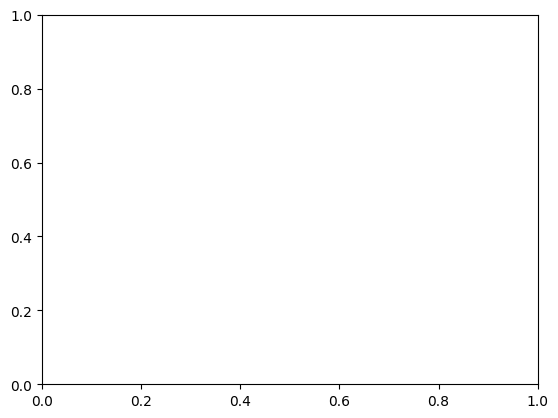

In [42]:
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
d = deque(maxlen=2)
d.append([0, 0])
i = 0

## \<skip>

In [ ]:
epochs = 1

In [ ]:
for epoch in range(epochs):
    print(f'[Seq2Seq] Epoch {epoch + 1}...')
    for y_b, x_b in dp:
        i += 1
        x_b = x_b.to(DEVICE)
        y_b = y_b.to(DEVICE)
        optimizer.zero_grad()
        outputs = seq2seq(x_b, y_b)
        loss_value = loss(outputs.permute(0, 2, 1), y_b)
#         print(f'\tLoss value is {loss_value:.3f}.')
        # #
        d.append([i, loss_value.item()])
        ax.plot(*zip(d[0], d[1]), color='royalblue')
        display(fig)
        clear_output(wait=True)
        plt.pause(0.01)
        # #
        loss_value.backward()
        torch.nn.utils.clip_grad_norm_(seq2seq.parameters(), 1)
        optimizer.step()
        scheduler.step()
    ax.axvline(x=i, color='r')

In [ ]:
for epoch in range(1):
    print(f'[Seq2Seq] Epoch {epoch + 1}...')
    for x_b, y_b in dp:
        i += 1
        x_b = x_b.to(DEVICE)
        y_b = y_b.to(DEVICE)
        optimizer.zero_grad()
        outputs = seq2seq(x_b, y_b)
        loss_value = loss(outputs.permute(0, 2, 1), y_b)
#         print(f'\tLoss value is {loss_value:.3f}.')
        # #
        d.append([i, loss_value.item()])
        ax.plot(*zip(d[0], d[1]), color='royalblue')
        display(fig)
        clear_output(wait=True)
        plt.pause(0.01)
        # #
        loss_value.backward()
        torch.nn.utils.clip_grad_norm_(seq2seq.parameters(), 1)
        optimizer.step()
        scheduler.step()
    ax.axvline(x=i, color='r')

6 эпох - сначала упал с 7 до 4 и плато

## train playground

In [ ]:
# dpp = [i for i in islice(dp, 10)]

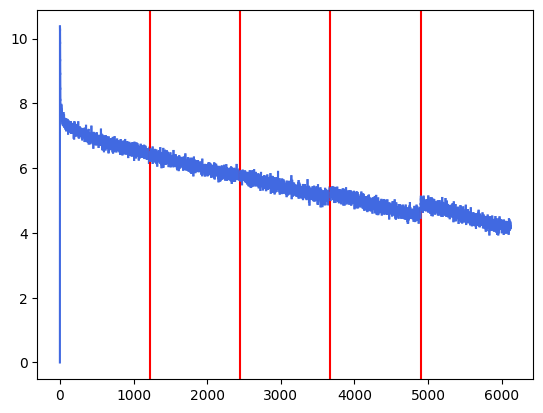

In [56]:
epochs = 2
n_batches = 1225
seq2seq.train()
last_epoch_loss = 0

for epoch in range(epochs):
    print(f'Epoch {epoch} loss: {last_epoch_loss}')
    print(f'[Seq2Seq] Epoch {epoch + 1}...')
    epoch_loss = 0.
    for y_b, x_b in dp:
        i += 1
        x_b = x_b.to(DEVICE)
        y_b = y_b.to(DEVICE)

        optimizer.zero_grad()
        outputs = seq2seq(x_b, y_b, 0.2)
#         print(outputs.shape)
#         print(y_b.shape)
#         break
        loss_value = loss(outputs.permute(0, 2, 1), y_b)
        epoch_loss += loss_value.item()

        # # graph
        d.append([i, loss_value.item()])
        ax.plot(*zip(d[0], d[1]), color='royalblue')
        display(fig)
        clear_output(wait=True)
#         plt.pause(0.01)
        # #

        loss_value.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(seq2seq.parameters(), 1)

#         x_b_ = x_b.to('cpu')
#         y_b_ = y_b.to('cpu')
#         del x_b_
#         del y_b_

    scheduler.step()
    ax.axvline(x=i, color='r')
    last_epoch_loss = epoch_loss / n_batches

In [57]:
torch.save(
    {
        'epoch': 5,
        'en2ru': seq2seq.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'loss': last_epoch_loss,
        'en_voc': en_voc,
        'ru_voc': ru_voc,
    }, './en2ru_e5_model.pt'
)

In [ ]:
checkpoint = torch.load('/kaggle/input/s2s-model/seq2seq.pt', map_location=torch.device('cpu'))

seq2seq.load_state_dict(checkpoint)

In [ ]:
seq2seq

In [ ]:
ru_itos = ru_voc.get_itos()
en_itos = en_voc.get_itos()
seq2seq.eval()
with torch.no_grad():
    for y_b, x_b in dp:
        x_b = x_b.to(DEVICE)
        y_b = y_b.to(DEVICE)
        outputs = seq2seq(x_b, y_b)
        print(outputs.shape)
        res = outputs.softmax(2).argmax(2)
        for k, r in enumerate(res):
            print(*[en_itos[e_i] for e_i in list(x_b[k])])
            a = ' '.join([ru_itos[r_i] for r_i in list(r)])
            print(a)
#             print(list(r))
            print('---')
            break
        break

In [58]:
ru_itos = ru_voc.get_itos()
en_itos = en_voc.get_itos()
seq2seq.eval()
with torch.no_grad():
    x_b = torch.tensor([[    1, 12679,    99,    20,    25,   148,    30,   568,   619,    14,
             23,     2,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0]])
    y_b = torch.tensor([[    1, 12679,    99,    20,    25,   148,    30,   568,   619,    14,
             23,     2,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0]])
    outputs = seq2seq(x_b, y_b)
    print(outputs.shape)
    res = outputs.softmax(2).argmax(2)
    for k, r in enumerate(res):
        print(*[en_itos[e_i] for e_i in list(x_b[k])])
        a = ' '.join([ru_itos[r_i] for r_i in list(r)])
        print(a)
        print('---')

torch.Size([1, 32, 31834])
<sos> Hello world it was me I love play with you <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <unk> В В 2 2 того того это из из <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
---


In [72]:
ru_itos = ru_voc.get_itos()
en_itos = en_voc.get_itos()
seq2seq.eval()

t = get_test_dp(
    [
        'Почему когда идет дождь президент под зонтом?',
        'Когда он пойдет на улицу за водой?',
        'Это есть причина твоей смерти',
        'Зачем ты пукнул'
    ],
    exp, ru_voc, lambda x: len(x) <= MAX_TOKENS, ru_doc_transform, 4, 32)

with torch.no_grad():
    for x_b in t:
        outputs = seq2seq(x_b, x_b)
        res = outputs.softmax(2).argmax(2)
        for k, r in enumerate(res):
            print(*[ru_itos[e_i] for e_i in list(x_b[k])])
            a = ' '.join([en_itos[r_i] for r_i in list(r)])
            print(a)
            print('---')

<sos> Почему когда идет дождь президент под <unk> <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> Why when when the President President President under under the <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
---
<sos> Это есть причина твоей смерти <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> It is is the of the death <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
---
<sos> Зачем ты <unk> <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> Why you you <eos> <eos> <eos> <eos> <eo